# COMP90086 Workshop 12 (Local version)

In this workshop, we will discuss object detection. We will use the [Tensorflow 2 Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection) with pre-trained models from the [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) to detect objects in images. We will then visualise and evaluate the results with the open-source tool [FiftyOne](https://voxel51.com/docs/fiftyone/).


Table of Contents

- 1 Installation
    - (1) Testing the availability of the Tensorflow 2.x module
    - (2) TensorFlow Object Detection API Installation    
    
- 2 Object Detection From Pre-trained Model
    - (1) Download the model
    - (2) Load the model
    - (3) Download the test dataset
    - (4) Make predictions
    
- 3 Evaluation
    - (1) Definitions of different metrics
    - (2) Running evaluation
    - (3) Aggregate results
    - (4) Evaluating model mAP
    - (5) Sample-level analysis
    
- 4 Exercise


> **Important**: If you have not yet set up your development environment, please follow the steps of `Installation` below or refer to the [installation instructions](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html) to set up your development environment first. Note that the setting up of the environment can be time consuming. We strongly recommend that you use the Colab version of the Notebook and run it on Google Colab, which runs only one code block to configure all the required environment.


This tutorial is adapted from the TensorFlow 2 Object Detection API tutorial and the FiftyOne Docs:
<table class="tfo-notebook-buttons" align="left">
    <td>
    <a target="_blank" href="http://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/?badge=latest">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png"/>
    View on Object Detection API Document</a>
  </td>   
  <td>
    <a target="_blank" href="https://voxel51.com/docs/fiftyone/">   
    <img src="https://voxel51.com/images/logo/voxel51-logo-horz-color-600dpi.png" width=117/>
    View on FiftyOne Docs</a>
  </td>
</table>

## 1 Installation

In [1]:
import os
os.chdir('TensorFlow/models/research') #please change to YOURPATH
import time
import json
import pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
tf.get_logger().setLevel('ERROR') # Suppress TensorFlow logging
import warnings
warnings.filterwarnings("ignore") # Suppress warnings
import sys
# install FiftyOne
!{sys.executable} -m pip install fiftyone

import fiftyone as fo
from PIL import Image

### (1) Testing the availability of the Tensorflow 2.x module

In contrast to TensorFlow 1.x, where different Python packages needed to be installed for one to run TensorFlow on either their CPU or GPU (namely `tensorflow` and `tensorflow-gpu`), TensorFlow 2.x only requires that the `tensorflow` package is installed and automatically checks to see if a GPU can be successfully registered.

In [2]:
print("TensorFlow version: ", tf.__version__)

TensorFlow version:  2.4.1


#### (Optional) GPU Support 

Although using a GPU to run TensorFlow is not necessary, the computational gains are substantial. Therefore, if your machine is equipped with a compatible CUDA-enabled GPU, it is recommended that you refer to the the [GPU Support](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#gpu-support-optional) to install the relevant libraries necessary to enable TensorFlow to make use of your GPU.

### (2) TensorFlow Object Detection API Installation

#### 1 [Downloading the TensorFlow Model Garden](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#downloading-the-tensorflow-model-garden)

- Create a new folder under a path of your choice and name it `TensorFlow`. (e.g. `C:\Users\username\Week12_Local\TensorFlow`).

- From your Terminal `cd` into the `TensorFlow` directory.

- To download the models you can either use [Git](https://git-scm.com/downloads) to clone the [TensorFlow Models repository](https://github.com/tensorflow/models) inside the `TensorFlow` folder, or you can simply download it as a [ZIP](https://github.com/tensorflow/models/archive/master.zip) and extract its contents inside the `TensorFlow` folder. To keep things consistent, in the latter case you will have to rename the extracted folder `models-master` to `models`.

- You should now have a single folder named `models` under your `TensorFlow` folder, which contains another 4 folders as such:

```
Week12_Local
├─ Workshop12(Local_version).ipynb
├─ datasets
└─ TensorFlow/
     └─ models/
         ├─ community/
         ├─ official/
         ├─ orbit/
         ├─ research/
         └── ...
```

#### 2 [Protobuf Installation/Compilation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#coco-api-installation)

The Tensorflow Object Detection API uses Protobufs to configure model and training parameters. Before the framework can be used, the Protobuf libraries must be downloaded and compiled.

- (Windows/Linux) 
  - Please refer to [Protobuf Installation/Compilation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#protobuf-installation-compilation)

- (macOS) 
  - [Install Homebrew](https://brew.sh/)

  - Install Protocol Buffers on Mac can be done using Homebrew by running the command `brew install protobuf`
  

#### 3 [COCO API installation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#coco-api-installation)
As of TensorFlow 2.x, the `pycocotools` package is listed as a dependency of the Object Detection API.

- (Windows/Linux) 
  - Please refer to [COCO API installation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#coco-api-installation)

- (macOS) 
  - Same as the method for Windows in [COCO API installation](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#coco-api-installation)

#### 4 [Install the Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html#install-the-object-detection-api)

Due to potential port binding issues, we install this API after launch the FiftyOne API. (see **Install Tensorflow 2 Object Detection API** in **2(4)Make predictions**)

## 2 Object Detection From Pre-trained Model

This demo will take you through the steps of running an "out-of-the-box" TensorFlow 2 compatible
detection model on a collection of images. We will utilise the [TensorFlow 2 Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection). The TensorFlow Object Detection API is an open source framework built on top of TensorFlow that makes it easy to construct, train and deploy object detection models. 

### (1) Download the model

We will use the pre-trained models from the Model Zoo to detect objects in images. 

The [Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md) is a collection of detection models pre-trained on the COCO 2017 dataset. The [COCO 2017 dataset](https://cocodataset.org/#home) is a large-scale dataset of labelled images. It contains 80 common object categories. The models can perform object detection on these object categories. You can explore the COCO dataset by using the the [COCO dataset explorer page](https://cocodataset.org/#explore).

You might find that there are plenty of models available in the Model Zoo. The architecture of all these models can be identified by name. In this workshop, we suggest you to try some of the following models. You could compare and contrast the results of the Faster R-CNN, SSD, and CenterNet. You could also try swapping the "backbone" of a network (e.g., ResNet vs. MobileNet) to see if it changes the results.

| Name | MODEL_NAME   | MODEL_DATE | Speed (ms) | COCO mAP |
|------|--------------|------------|------------|----------|
|[CenterNet Resnet50 V2 512x512](http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v2_512x512_coco17_tpu-8.tar.gz)|`centernet_resnet50_v2_512x512_coco17_tpu-8`|`20200711`|27|29.5|
|[CenterNet Resnet50 V1 FPN 512x512](http://download.tensorflow.org/models/object_detection/tf2/20200711/centernet_resnet50_v1_fpn_512x512_coco17_tpu-8.tar.gz)|`centernet_resnet50_v1_fpn_512x512_coco17_tpu-8`|`20200711`|27|31.2|
|[CenterNet HourGlass104 512x512](http://download.tensorflow.org/models/object_detection/tf2/20200713/centernet_hg104_512x512_coco17_tpu-8.tar.gz)|`centernet_hg104_512x512_coco17_tpu-8`|`20200713`|70|41.9|
|[SSD ResNet50 V1 FPN 640x640 (RetinaNet50)](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz)|`ssd_resnet50_v1_fpn_640x640_coco17_tpu-8`|`20200711`|46|34.3|
|[SSD ResNet101 V1 FPN 640x640 (RetinaNet101)](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet101_v1_fpn_640x640_coco17_tpu-8.tar.gz)|`ssd_resnet101_v1_fpn_640x640_coco17_tpu-8`|`20200711`|57|35.6|
|[SSD MobileNet V1 FPN 640x640](http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8.tar.gz)|`ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8`|`20200711`|48|29.1|
|[Faster R-CNN ResNet50 V1 640x640](http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz)|`faster_rcnn_resnet50_v1_640x640_coco17_tpu-8`|`20200711`|53|29.3|
|[Faster R-CNN ResNet50 V1 800x1333](http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8.tar.gz)|`faster_rcnn_resnet50_v1_800x1333_coco17_gpu-8`|`20200711`|65|31.6|
|[Faster R-CNN ResNet101 V1 640x640](http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet101_v1_640x640_coco17_tpu-8.tar.gz)  | `faster_rcnn_resnet101_v1_640x640_coco17_tpu-8` |  `20200711` | 55|   31.8 |
|[Faster R-CNN Inception ResNet V2 640x640](http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8.tar.gz)  | `faster_rcnn_inception_resnet_v2_640x640_coco17_tpu-8` |  `20200711` | 206|   37.7 |

More models can be found in the [TensorFlow 2 Detection Model Zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md).

#### Metrics in the table
    - Speed (ms) is the expected response time to get a response when querying the model, the lower the better.  
    - COCO mAP is the mean average precision score against the COCO dataset of images, the higher the better.

The code snippet shown below is used to download the pre-trained object detection model we shall
use to perform inference. The particular pre-trained model we will use is the `CenterNet MobileNetV2 FPN 512x512`.  To use a different model you will need to:

1. Copy the `MODEL_NAME` part of the table and use it to replace the value of the `MODEL_NAME` variable in the code shown below;
2. Copy the `MODEL_DATE` part of the table and use it to replace the value of the `MODEL_DATE` variable in the code shown below.

For example, if we want to switch to the `CenterNet Resnet50 V1 FPN 512x512` model, then the following block should use code:
```
MODEL_DATE = '20200711'
MODEL_NAME = 'centernet_resnet50_v1_fpn_512x512_coco17_tpu-8'
```

More information on the functions used below, see:
- [tf.keras.utils.get_file( )](https://www.tensorflow.org/api_docs/python/tf/keras/utils/get_file) Downloads a file from a URL if it not already in the cache.

In [3]:
# Download and extract model
def download_model(model_name, model_date):
    base_url = 'http://download.tensorflow.org/models/object_detection/tf2/'
    model_file = model_name + '.tar.gz'
    model_dir = tf.keras.utils.get_file(fname=model_name,
                                        origin=base_url + model_date + '/' + model_file,
                                        untar=True, #Whether the file should be decompressed
                                        cache_dir="../../../") #Location to store cached files
    return str(model_dir)
MODEL_DATE = '20200711'
MODEL_NAME = 'ssd_mobilenet_v1_fpn_640x640_coco17_tpu-8'
PATH_TO_MODEL_DIR = download_model(MODEL_NAME, MODEL_DATE)

### (2) Load the model
Next we load the downloaded model. In this example we will be using
the [Saved Model Format](https://www.tensorflow.org/guide/saved_model) to load the model.

In [4]:
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"

print('Loading model...', end='')
start_time = time.time()

# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)

end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...

2021-10-16 20:09:49.604686: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-16 20:09:49.604839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Done! Took 5.66827917098999 seconds


### (3) Download the test dataset

To speed up the experiment, the test set we used in the workshop contained only fifty images. These images and their ground truths are taken from the [COCO 2017 Validation dataset](https://cocodataset.org/#download) (Note: The official COCO test set annotations are unavailable to the public).

In [5]:
# Load COCO formatted dataset ground_truth
coco_dataset = fo.Dataset.from_dir(
    dataset_type=fo.types.COCODetectionDataset,
    data_path='../../../datasets/images/',
    labels_path='../../../datasets/coco.json',
    include_id=True,
    label_field="ground_truth",
    #label_field="",
)

 100% |███████████████████| 50/50 [167.4ms elapsed, 0s remaining, 300.2 samples/s] 


Let’s inspect the dataset

In [6]:
# Print some information about the dataset
print(coco_dataset)

Name:        2021.10.16.20.09.54
Media type:  image
Num samples: 50
Persistent:  False
Tags:        []
Sample fields:
    id:                      fiftyone.core.fields.ObjectIdField
    filepath:                fiftyone.core.fields.StringField
    tags:                    fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:    fiftyone.core.fields.IntField


In [7]:
# Print a ground truth detection
sample = coco_dataset.first()
print(sample.ground_truth_detections.detections[0])

<Detection: {
    'id': '616a96e3434ddec62510b830',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'person',
    'bounding_box': BaseList([
        0.30445833333333333,
        0.46070312500000005,
        0.22441666666666665,
        0.293421875,
    ]),
    'mask': None,
    'confidence': None,
    'index': None,
    'supercategory': 'person',
    'iscrowd': 0,
}>


In [8]:
# Export labels in COCO format
with open("../../../datasets/coco.json") as f:
    data = json.load(f)

# Explore labels    
data['categories']

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

#### Visualizing and exploring your dataset with FiftyOne App

[FiftyOne](https://voxel51.com/docs/fiftyone/index.html#) is a open-source tool for building datasets and computer vision models. It enables you to visualize datasets and interpret models faster and more effectively.

Connected to FiftyOne on local port 5151
If you are not connecting to a remote session, you may need
to start a new session and specify a port.




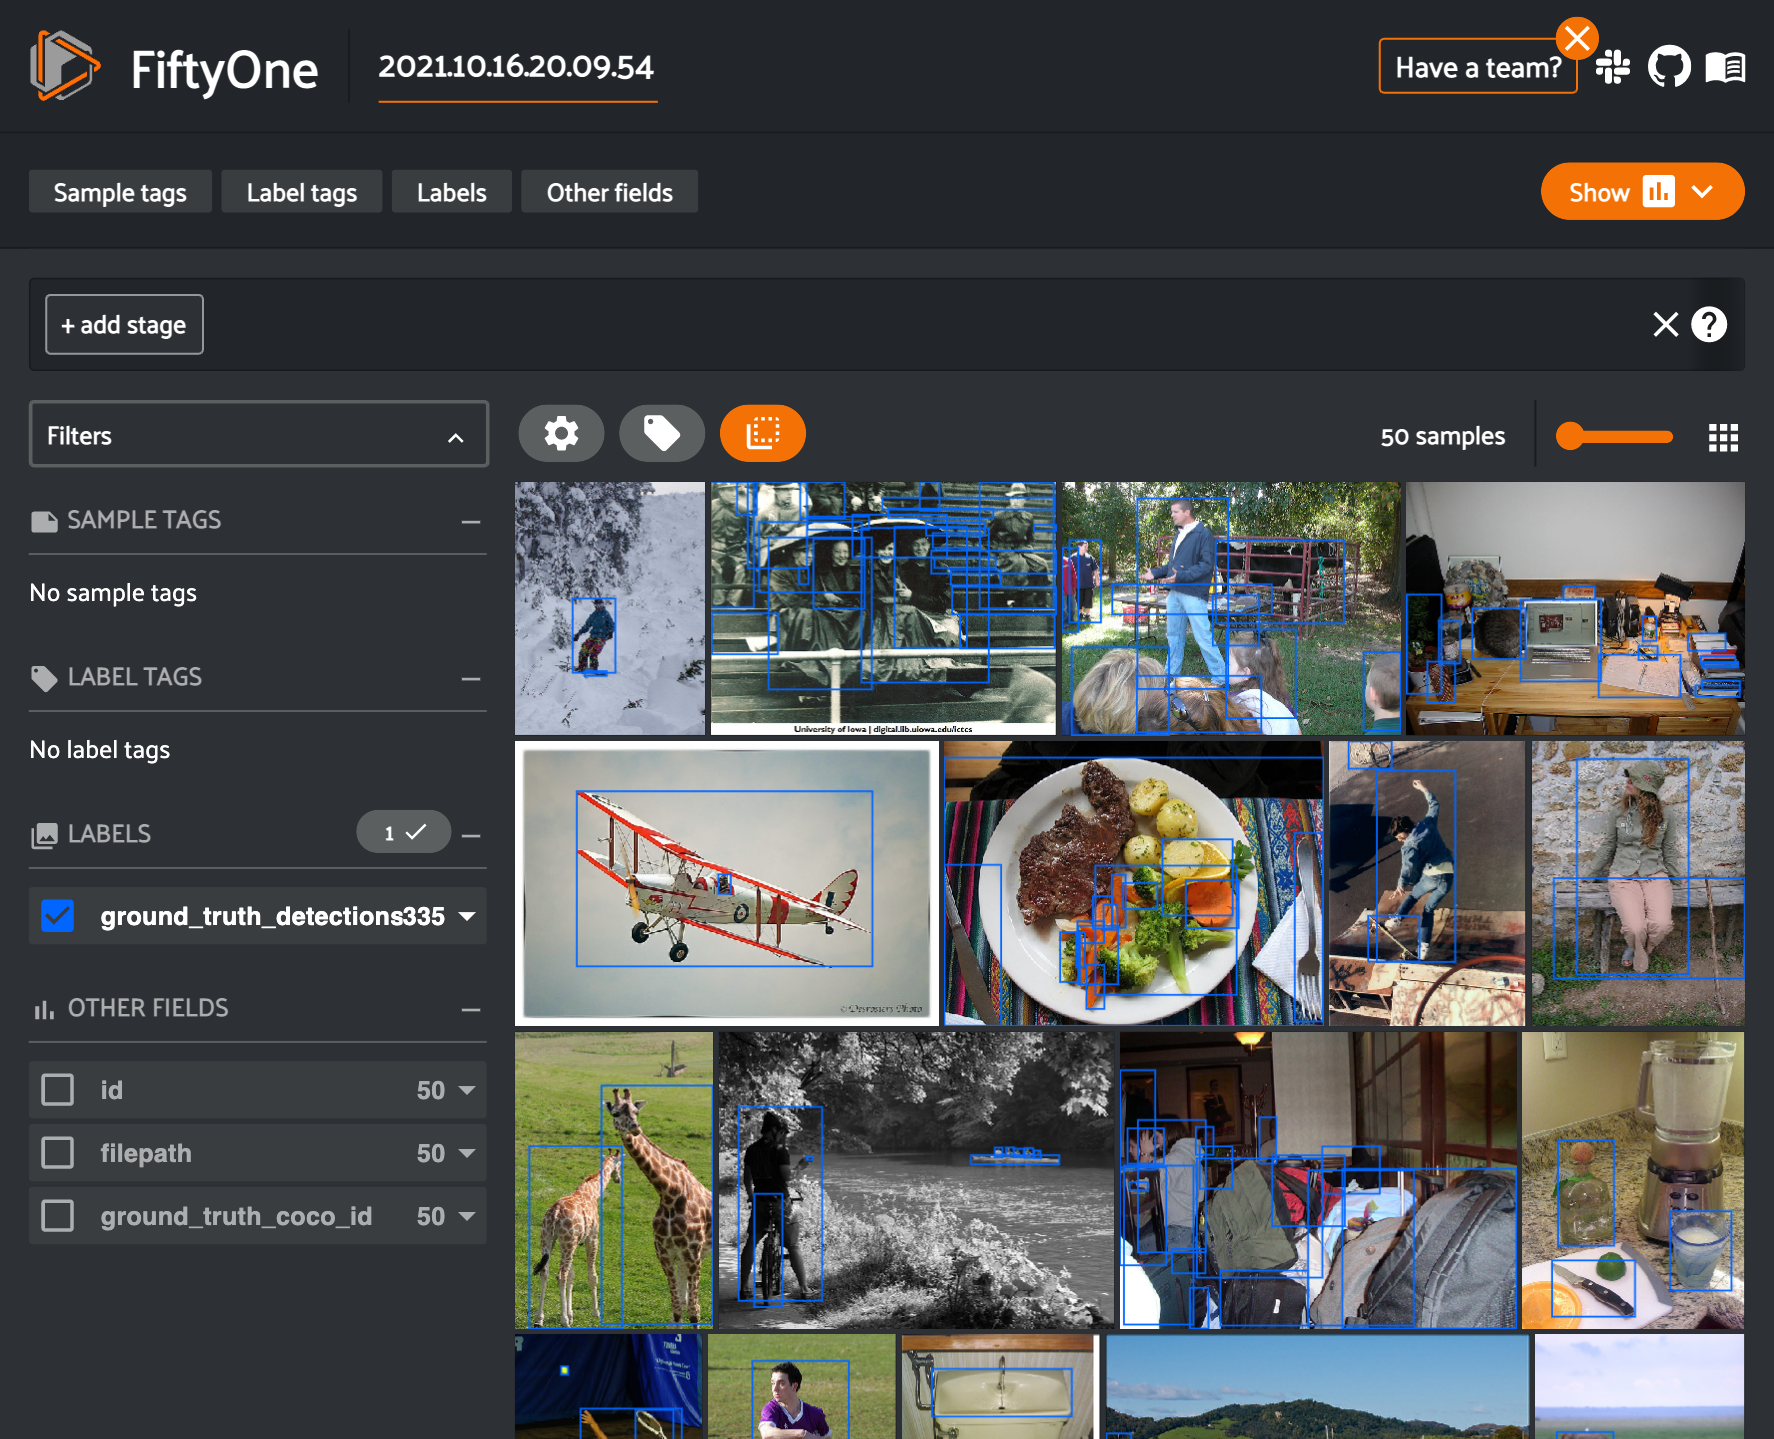

In [9]:
session = fo.launch_app(coco_dataset)

#### (Optional) Split your own sub-dataset from the COCO

You could also split your own sub-dataset from the COCO 2017 validation dataset.

Below we will load 50 random samples from the COCO 2017 validation split that contain cats and dogs. Images that contain all `classes` will be prioritized first, followed by images that contain at least one of the required `classes`. If there are not enough images matching `classes` in the split to meet `max_samples`, only the available images will be loaded. By default, only detections are loaded. By setting `shuffle=True`, it will randomly shuffle the order in which samples are chosen for partial downloads.

> **Important**: If you do not intend to split your own dataset, **do not execute the one block of code below**. Once the following one block is executed, FiftyOne will perform a download, which can be very large.

In [10]:
# import fiftyone.zoo as foz

# my_dataset = foz.load_zoo_dataset(
#     "coco-2017",
#     split="validation",
#     classes=["cat", "dog"],
#     max_samples=50,
#     shuffle=True,
# )

# # Print some information about the dataset
# print(my_dataset)

> If your are using this `my_dataset`: please replace `coco_dataset` with `my_dataset`, and replace `ground_truth_detections` with `ground_truth` in all the following code.

In addition to loading the COCO datasets themselves,  you could load your own datasets stored in [COCO format](https://cocodataset.org/#format-data) using [this guide](https://voxel51.com/docs/fiftyone/integrations/coco.html#loading-coco-formatted-data).

### (4) Make predictions

Installation of the Object Detection API is achieved by installing the `object_detection` package. Install Tensorflow 2 Object Detection API. This is done by running the following commands from within `Tensorflow/models/research` .

In [11]:
!protoc object_detection/protos/*.proto --python_out=.
!cp object_detection/packages/tf2/setup.py .
!python -m pip install --use-feature=2020-resolver .

Processing /Users/jiayang/Desktop/week12_local_update/TensorFlow/models/research


  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1668658 sha256=f8f9677292fec67850d36de5d16ab4bf37edae5ddea387ac694ff0ee3a1d49c0
  Stored in directory: /private/var/folders/w3/sps3jkcd6q9_43wpmcvjt9300000gn/T/pip-ephem-wheel-cache-owt0zyfu/wheels/97/46/c6/6cc7d6d4e8e7b895db664631a12b5fc327fee533115cdcf173
Successfully built object-detection
  Attempting uninstall: object-detection
    Found existing installation: object-detection 0.1
    Uninstalling object-detection-0.1:
      Successfully uninstalled object-detection-0.1


In [12]:
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils

Now, we will use the chosen pre-trained model to make predictions on our dataset.

You could set `min_score_thresh` to other values (between 0 and 1) to allow more detections in or to filter out more detections.

In [13]:
min_score_thresh=.30

In [14]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
      path: the file path to the image

    Returns:
      uint8 numpy array with shape (img_height, img_width, 3)
    """
    return np.array(Image.open(path))

# Choose a random subset of 25 samples to add predictions.
# The larger the sample you choose, the longer it will take.
predictions_view = coco_dataset.take(25, seed=51)

# Get class list
classes = coco_dataset.default_classes

# Add predictions to samples
with fo.ProgressBar() as pb:
    for sample in pb(predictions_view):
        # Load image
        image_np = load_image_into_numpy_array(sample.filepath)

        # Things to try:
        # Convert image to grayscale
        # Here we still expect the input image to have 3 channels
        
        # image_np = np.tile(
        #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)
        
        
        
        # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
        input_tensor = tf.convert_to_tensor(image_np)
        
        # The model expects a batch of images, so add an axis with `tf.newaxis`.
        input_tensor = input_tensor[tf.newaxis, ...]

        # input_tensor = np.expand_dims(image_np, 0)
        detections = detect_fn(input_tensor)

        # All outputs are batches tensors.
        # Convert to numpy arrays, and take index [0] to remove the batch dimension.
        # We're only interested in the first num_detections.
        num_detections = int(detections.pop('num_detections'))
        detections = {key: value[0, :num_detections].numpy()
                       for key, value in detections.items()}
        detections['num_detections'] = num_detections

        # detection_classes should be ints.
        detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

        image_np_with_detections = image_np.copy()

        result_detections=[]
        for label, score, box in zip(detections['detection_classes'], detections['detection_scores'], detections['detection_boxes']):
            # Convert to [top-left-x, top-left-y, width, height]            
            ymin, xmin, ymax, xmax = box
            rel_box = [xmin, ymin, (xmax - xmin), (ymax - ymin)]

            # result_detections.append({"image_id": 1, "category_id": label, "bbox": rel_box, "score": score})
            if score>min_score_thresh:
                result_detections.append(
                    fo.Detection(
                        label=classes[label],
                        bounding_box=rel_box,
                        confidence=score
                    )
                )
                
        # Save predictions to dataset
        sample["mytest"] = fo.Detections(detections=result_detections)
        sample.save()

   0% ||------------------|  0/25 [5.7ms elapsed, ? remaining, ? samples/s] 

2021-10-16 20:10:01.860727: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


 100% |███████████████████| 25/25 [34.4s elapsed, 0s remaining, 0.8 samples/s]    


As our data is stored in COCO format, it can be loaded into FiftyOne and then visualised in this application. Let’s load `predictions_view` in the FiftyOne to visualize the predictions that we added:

In [15]:
session.view = predictions_view

## 3 Evaluation

Now that we have samples with ground truth and predicted objects, let’s use FiftyOne to evaluate the quality of the detections. FiftyOne provides a powerful [evaluation API](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html) that contains a collection of methods for performing evaluation of model predictions. Since we’re working with object detections here, we’ll use [detection evaluation](https://voxel51.com/docs/fiftyone/user_guide/evaluation.html#detections).

### (1) Definitions of different metrics

Adapted from [here](https://github.com/rafaelpadilla/Object-Detection-Metrics#important-definitions) and [here](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173).

#### True Positive, False Positive, False Negative and True Negative
Some basic concepts used by the metrics:
    
    - True Positive (TP): A correct detection. Detection with IOU ≥ threshold
    - False Positive (FP): A wrong detection. Detection with IOU < threshold
    - False Negative (FN): A ground truth not detected
    - True Negative (TN): Does not apply. It would represent a corrected misdetection. In the object detection task there are many possible bounding boxes that should not be detected within an image. Thus, TN would be all possible bounding boxes that were corrrectly not detected (so many possible boxes within an image). That's why it is not used by the metrics.

*threshold*: depending on the metric, it is usually set to 50%, 75% or 95%.

#### Precision, Recall and F1

    - Precision is the ability of a model to identify only the relevant objects. It is the percentage of correct positive predictions.

    - Recall is the ability of a model to find all the relevant cases (all ground truth bounding boxes). It is the percentage of true positive detected among all relevant ground truths.

Here are their mathematical definitions:

<img src="https://miro.medium.com/max/1068/1*EXa-_699fntpUoRjZeqAFQ.jpeg"/>


#### Micro/Macro/Weighted Average
    - Micro-average: aggregates the contributions of all classes to compute the average metric.  Basically, every sample-class pair contributes equally to the overall metric.

    - Macro-averaged: compute the metric independently for each class and then take the average, hence all classes equally contribute to the final averaged metric.

    - Weighted-averaged: each classes’s contribution to the average is weighted by its sample size.

See [here](https://tomaxent.com/2018/04/27/Micro-and-Macro-average-of-Precision-Recall-and-F-Score/) for an example of their calculation

#### Intersection Over Union (IOU)

Intersection Over Union (IOU) is a measure based on Jaccard Index that evaluates the overlap between two bounding boxes. It requires a ground truth bounding box  and a predicted bounding box . By applying the IOU we can tell if a detection is valid (True Positive) or not (False Positive).

IOU is given by the overlapping area between the predicted bounding box and the ground truth bounding box divided by the area of union between them:  

<img src="https://camo.githubusercontent.com/3291322eb7cedb9ef86c2ede8c1993edcb44df235ffd39a8369dd5b549a40dba/68747470733a2f2f6c617465782e636f6465636f67732e636f6d2f6769662e6c617465783f25354374657874253742494f552537442533442535436672616325374225354374657874253742617265612537442535436c656674253238425f25374270253744253230253543636170253230425f2537426774253744253230253543726967687425323925374425374225354374657874253742617265612537442535436c656674253238425f25374270253744253230253543637570253230425f25374267742537442532302535437269676874253239253744"/>

The image below illustrates the IOU between a ground truth bounding box (in blue) and a detected bounding box (in red).

<img src="https://miro.medium.com/max/1400/1*FrmKLxCtkokDC3Yr1wc70w.png" width=600/>
<center>(image source: Jonathan Hui)</center>

####  Mean Average Precision (mAP)

mAP is a fairly complex metric (see [this blog](https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173) for a more detailed explanation). 

In short, mAP is calculated by:
    
    1.Matching prediction with ground truth object if they overlap above some IoU value. The COCO evaluation protocol introduces one additional step: mAP are averaged across a range of 10 IoU thresholds from 0.5 to 0.95 in increments of 0.05. 
    
    2.Computing the number of TP, FP, and FN separately for each class and IoU threshold. Using these TP/FP/FN to generate a precision-recall curve.
    
    3. Computing the average precision (AP) for each class and IoU threshold. Average Precision (AP) is the Area under the Precision-Recall Curve (AUC of PR-curve).
    
    4. For every class that contains at least one ground truth object, compute the AP by averaging the precision values over all 10 IoU thresholds. Then compute mAP by averaging the per-class AP values over all classes

Refer to [mAP protocol](https://voxel51.com/docs/fiftyone/integrations/coco.html#map-protocol) for the specific mAP calculation steps.


### (2) Running evaluation
We can run evaluation on our samples via [evaluate_detections( )](https://voxel51.com/docs/fiftyone/api/fiftyone.core.collections.html?highlight=evaluate_detections#fiftyone.core.collections.SampleCollection.evaluate_detections). Note that this method is available on both the Dataset and DatasetView classes, which means that we can run evaluation on our `predictions_view` to assess the quality of predictions in our dataset.

In [16]:
# Evaluate the predictions in the model field of our `predictions_view`
# with respect to the objects in the `ground_truth_detections` field

results = predictions_view.evaluate_detections(
    pred_field = "mytest", #the name of the field containing the predicted
    gt_field="ground_truth_detections", #the name of the field containing the ground truth
    eval_key="eval", 
    compute_mAP=True,
    iou=0.5 #the IoU threshold to use to determine matches
)

Evaluating detections...
 100% |███████████████████| 25/25 [501.5ms elapsed, 0s remaining, 49.8 samples/s]      
Performing IoU sweep...
 100% |███████████████████| 25/25 [658.1ms elapsed, 0s remaining, 38.0 samples/s]      


### (3) Aggregate results

The `results` object returned by the evaluation routine provides a number of convenient methods for analyzing our predictions. For example, let’s print a classification report for the top-10 most common classes in the dataset:

In [17]:
# Get the 10 most common classes in the dataset by setting [:10]
# You could remove [:10] to display all classes

counts = coco_dataset.count_values("ground_truth_detections.detections.label")
classes_top10 = sorted(counts, key=counts.get, reverse=True)[:10]

# Print a classification report for the top-10 classes
results.print_report(classes=classes_top10)

              precision    recall  f1-score   support

      person       0.57      0.68      0.62        31
       bench       0.40      1.00      0.57         4
     handbag       0.67      0.20      0.31        10
        boat       0.50      0.50      0.50         2
         car       0.29      0.62      0.40         8
      carrot       0.00      0.00      0.00         0
dining table       0.00      0.00      0.00         3
        book       0.12      0.33      0.18         9
    suitcase       0.33      0.33      0.33         3
    umbrella       1.00      0.33      0.50         3

   micro avg       0.37      0.52      0.43        73
   macro avg       0.39      0.40      0.34        73
weighted avg       0.47      0.52      0.45        73



To visualise the detection performance for specific objects, we can plot their precision-recall (P-R) curves. The P-R curve is generated by sweeping through a range of confidence thresholds on the detections. The area under the P-R curve is averaged over all classes to compute mAP.

In [18]:
plot = results.plot_pr_curves(classes=["person", "bench", "car"])
plot.show()

FigureWidget({
    'data': [{'hovertemplate': '<b>class: %{text}</b><br>recall: %{x}<br>precision: %{y}<extra>…

### (4) Evaluating model mAP

We can also compute the mean average-precision (mAP) of our detector (all mAP calculations are performed according to the [COCO evaluation protocol](https://cocodataset.org/#detection-eval)):

In [19]:
print(results.mAP())

0.417010403796085


### (5) Sample-level analysis
The evaluation routine also populated some new fields on our dataset that contain helpful information that we can use to evaluate our predictions at the sample-level.

In particular, each sample now contains new fields:

    - eval_tp: the number of true positive (TP) predictions in the sample
    - eval_fp: the number of false positive (FP) predictions in the sample
    - eval_fn: the number of false negative (FN) predictions in the sample

In [20]:
# Our dataset's schema now contains `eval_*` fields
print(coco_dataset)

Name:        2021.10.16.20.09.54
Media type:  image
Num samples: 50
Persistent:  False
Tags:        []
Sample fields:
    id:                      fiftyone.core.fields.ObjectIdField
    filepath:                fiftyone.core.fields.StringField
    tags:                    fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:                fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth_detections: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    ground_truth_coco_id:    fiftyone.core.fields.IntField
    mytest:                  fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)
    eval_tp:                 fiftyone.core.fields.IntField
    eval_fp:                 fiftyone.core.fields.IntField
    eval_fn:                 fiftyone.core.fields.IntField


The individual predicted and ground truth objects also have fields populated on them describing the results of the matching process:

    - eval: whether the object is a TP/FP/FN
    - eval_id: the ID of the matching ground truth/predicted object, if any
    - eval_iou: the IoU between the matching objects, if any

These extra fields were added because we provided the `eval_key` parameter to `evaluate_detections()`. If we had omitted this parameter, then no information would have been recorded on our samples.

In [21]:
# Our detections have helpful evaluation data on them
sample = predictions_view.first()
print(sample.mytest.detections[0])

<Detection: {
    'id': '616a96ec434ddec62510bb0b',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'car',
    'bounding_box': BaseList([
        0.23246514797210693,
        0.5930321216583252,
        0.3895948529243469,
        0.2664142847061157,
    ]),
    'mask': None,
    'confidence': 0.7834392786026001,
    'index': None,
    'eval': 'tp',
    'eval_id': '616a96e3434ddec62510ba42',
    'eval_iou': 0.944630925751489,
}>


## 4 Exercise
### Exercise 1
Compare and contrast the results of the Faster R-CNN, SSD, and CenterNet. Also try swapping the "backbone" of a network (e.g., ResNet vs. MobileNet) to see if it changes the results. (Hints: change the `MODEL_DATE` and ` MODEL_NAME` in **2(1) Download the model**)

### Exercise 2
Try changing `min_score_thresh` in **2(4) Make predictions** to other values (between 0 and 1). How does this affect the results of detections? Why?

### Exercise 3
Modify some of the input images and see if detection still works. For example, converting the images to grayscale (just uncomment the relevant portions of code in **2(4) Make predictions**), or splitting your own sub-dataset from the COCO (see **2(3)(Optional)**).